In [1]:
import numpy as np
import xarray as xr
import pandas as pd

# Load SST and grid data (assume same for both JRA and CORE2)
npz = np.load('sstu_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
sst = npz["sstc"]
coast = npz["coast"]
lono = npz["lonc"]
lato = npz["latc"]
time = npz["time"]
lat = np.mean(lato, axis=1)  

# Prepare heat budget list: [JRA, CORE2]
heat_budget_files = [
    ('heat_budget_mld1_fjra_1993_2022.npz', 'JRA'),
    ('heat_budget_mld1_fera5_1993_2022.npz', 'ERA5'),
    ('heat_budget_mld1_fcore2_1993_2009.npz', 'CORE2'),

]

heat_budgets = []
for fname, label in heat_budget_files:
    npz = np.load(fname, allow_pickle=True)
    print(f"Keys in the npz file ({label}):", npz.keys())
    budget = {
        'advx': npz['advx_c'],
        'advy': npz['advy_c'],
        'advz': npz['advz_c'],
        'diffv': npz['diffv_c'],
        'sbc': npz['sbc_c'],
        'tdc': npz['tdc_c'],
        'label': label
    }
    heat_budgets.append(budget)

# Now heat_budgets[0] is JRA, heat_budgets[1] is CORE2, each a dict with all terms and a label


Keys in the npz file: KeysView(NpzFile 'sstu_1993_2022.npz' with keys: lon, lat, sstu, sstc, coast...)
Keys in the npz file (JRA): KeysView(NpzFile 'heat_budget_mld1_fjra_1993_2022.npz' with keys: advx_c, advy_c, advz_c, diffv_c, sbc_c...)
Keys in the npz file (ERA5): KeysView(NpzFile 'heat_budget_mld1_fera5_1993_2022.npz' with keys: advx_c, advy_c, advz_c, diffv_c, sbc_c...)
Keys in the npz file (CORE2): KeysView(NpzFile 'heat_budget_mld1_fcore2_1993_2009.npz' with keys: advx_c, advy_c, advz_c, diffv_c, sbc_c...)


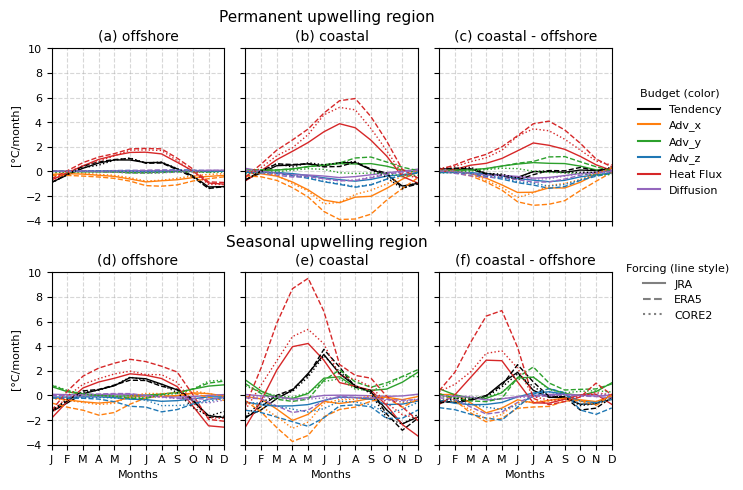

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
panel_labels = list("abcdefghijklmnopqrstuvwxyz")

def plot_budget_results_compare(lat, heat_budgets, latitude_bands):
    """
    Plot the mean evolution of budget terms for specified latitude bands (no error bars),
    comparing JRA (solid) and CORE2 (dashed).
    """
    labels = ["Tendency", "Adv_x", "Adv_y", "Adv_z", "Heat Flux", "Diffusion"]
    colors = {
        "Tendency": "k", 
        "Adv_x": "tab:orange",
        "Adv_y": "tab:green", 
        "Adv_z": "tab:blue",
        "Heat Flux": "tab:red", 
        "Diffusion": "tab:purple",
    }
    linestyles = {
        "JRA": "solid",
        "ERA5": "dashed",
        "CORE2": "dotted",
    }
    fig, axes = plt.subplots(len(latitude_bands), 3, figsize=(7, 5), sharex=True, sharey=True)

    for row, (lat_min, lat_max) in enumerate(latitude_bands):
        mask = (lat >= lat_min) & (lat <= lat_max)
        for col in range(3):  # 0: offshore, 1: coastal, 2: diff
            ax = axes[row, col]
            for budget in heat_budgets:
                label_prefix = budget['label']
                linestyle = linestyles.get(label_prefix, "solid")
                # Get the terms in the correct order
                terms = [budget['tdc'], budget['advx'], budget['advy'], budget['advz'], budget['sbc'], budget['diffv']]
                for term, label in zip(terms, labels):
                    color = colors.get(label, None)
                    if col == 0:  # offshore
                        mean_evolution = np.nanmean(term[:, mask, :8], axis=(1, 2)) * dt
                    elif col == 1:  # coastal
                        mean_evolution = np.nanmean(term[:, mask, 8:], axis=(1, 2)) * dt
                    else:  # diff (coastal - offshore)
                        mean_coastal = np.nanmean(term[:, mask, 8:], axis=(1, 2))
                        mean_offshore = np.nanmean(term[:, mask, :8], axis=(1, 2))
                        mean_evolution = (mean_coastal - mean_offshore) * dt

                    # Only show legend for first row, last col, and only for term (color)
                    show_legend = (row == 0 and col == 2 and label_prefix == "JRA")
                    legend_label = label if show_legend else "_nolegend_"
                    ax.plot(
                        range(term.shape[0]), mean_evolution,
                        label=legend_label,
                        color=color,
                        linestyle=linestyle,
                        linewidth=1
                    )
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.set_ylim(-4, 10)
            ax.set_xlim(0, term.shape[0] - 1)
            panel_idx = row * 3 + col
            prefix = f"({panel_labels[panel_idx]}) "
            title = ["offshore", "coastal", "coastal - offshore"][col]
            ax.set_title(f"{prefix}{title}", fontsize=10)
            if col == 0:
                ax.set_ylabel("[°C/month]")

    for ax in axes[-1, :]:  
        ax.set_xticks(range(12))
        ax.set_xticklabels(month_labels)
        ax.set_xlabel("Months")

    # Build legend: only show one entry per term (color), and a separate legend for line style (experiment)
    # 1. Term legend (color)
    term_lines = []
    term_labels = []
    for label in labels:
        color = colors.get(label, None)
        line, = plt.plot([], [], color=color, linestyle='solid')
        term_lines.append(line)
        term_labels.append(label)
    # 2. Experiment legend (line style)
    exp_lines = []
    exp_labels = []
    for label_prefix, linestyle in linestyles.items():
        line, = plt.plot([], [], color='gray', linestyle=linestyle)
        exp_lines.append(line)
        exp_labels.append(label_prefix)
    # Place legends at the right
    # Place term legend (color) at upper right outside the axes
    fig.legend(term_lines, term_labels, loc='center left', bbox_to_anchor=(0.9, 0.7), ncol=1, frameon=False, title="Budget (color)")
    # Place experiment legend (line style) below term legend
    fig.legend(exp_lines, exp_labels, loc='center left', bbox_to_anchor=(0.883, 0.4), ncol=1, frameon=False, title="Forcing (line style)")
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  
    fig.subplots_adjust(hspace=0.3)   


    row_titles = [
        "Permanent upwelling region",
        "Seasonal upwelling region"
    ]

    for i, title in enumerate(row_titles):
        y = 1.0 - (i + 0.5) * .45 + 0.16

        fig.text(
            0.47, y, title,
            ha='center', va='bottom',
            fontsize=11
        )

# Latitude bands
dt = 86400 * 30  # seconds in 1 month
latitude_bands = [(21, 30), (12, 19)]
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

plot_budget_results_compare(
    lat,
    heat_budgets,
    latitude_bands
)
plt.savefig("figA1.png", dpi=300, bbox_inches='tight')                    
plt.show()